# Inicializace

In [65]:
from collections import deque               # Ukladani stavu
from __future__ import division             # Deleni realnych cisel (kvuli verzi Pythonu 2.6)
import sys                                  # Pro navazani knihovny Open AI Gym
import numpy as np                          # Knihovna pro operace s maticemi
sys.path.append('/home/xbucha02/libraries') # Adresa knihovny Open AI Gym
import gym                                  # Knihovna Open AI Gym
#from gym import wrappers                    # Pomucka na nahravani
env = gym.make('CartPole-v0')            # Konkretni hra z Open AI Gym
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu
gpuMemoryUsage=1                            # Vyuziti pameti GPU
#import tensorflow as tf                     # Knihovna TensorFlow pro sdileni GPU
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
#set_session(tf.Session(config=config))
import random

%matplotlib inline  
import matplotlib.pyplot as plt

# Parametry
observetime = 500                  # Pocet framu kazde hry
startEpsilon = 1                   # Pravdepodobnost konani nahodneho tahu na zacatku
endEpsilon = 0.1                   # Pravdepodobnost konani nahodneho tahu na konci
currentEpsilon = startEpsilon      # Soucasna pravdepodobnost konani nahodneho tahu
epsilonDiminution = 0.995          # Hodnota snizovani epsilonu
gamma = 0.95                       # Snizujici faktor
minibatchSize = 32                 # Velikost minibatche
episodes = 500                    # Pocet epizod
#numberOfGames = 20                # Pocet her na konci
actionCount = env.action_space.n   # Pocet akci v danem prostredi
stateSize = env.observation_space.shape[0]
learningRate = 0.001             # Learning rate
memorySize = 2000                  # Replay pamet

# Model NN

In [66]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

def getDQN(actionCount,stateSize):
    net = Sequential()
    #net.add(Dense(20, activation="relu", kernel_initializer="uniform", input_shape=(2, 2)))
    #net.add(Flatten())
    net.add(Dense(24, activation="relu", input_dim=stateSize))
    #net.add(Flatten())
    net.add(Dense(24, activation="relu"))
    #net.add(Dropout(rate=0.5))
    #net.add(Dense(8, activation="relu", kernel_initializer="uniform"))
    
    net.add(Dense(actionCount, activation="linear"))
    
    net.summary()
    net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    
    return net

In [67]:
net = getDQN(actionCount, stateSize)
observation = env.reset()                    # Reset prostredi
memory = deque(maxlen=memorySize)

global scores
scores = []
global episodes
episodesList = []
for eps in range (episodes):  
    #stateF = state[0][1] #np.reshape(state, [1, stateSize])
    #D = deque() #vyprazdneni D
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    #env.render()
    #obs = np.expand_dims(observation, axis=0) 
    #state = np.stack((obs, obs), axis=1)

    i = 0
    for t in range(observetime):
        #if i == 0:
            
        #else:
        #    if i==4:
        #        i = 0
        #    else:
        #        i = i + 1
        if np.random.rand() <= currentEpsilon:
            action = np.random.randint(0, actionCount, size=1)[0]
        else:
            #print("shirt")
            Q = net.predict(state)
            #print("shirt")
            action = np.argmax(Q)
            #print("{}".format(action))
        #print ("state: {}" .format(state))
        #print("{}".format(action))
        
        #state = np.reshape(state[0][1], [1, stateSize])
        #print ("state: {}" .format(state))
        observation_new, reward, done, info = env.step(int(action))
        
        #print()
        #stateNewF = observation_new
        #print("heje{}".format(stateNewF))
        #obs_new = np.expand_dims(observation_new, axis=0)        
        #print ("obs_new: {}" .format(obs_new))
        #state_new = np.append(np.expand_dims(obs_new, axis=0), state[:, :1, :], axis=1)
        #state = state[0][0]#next_state = np.reshape(next_state, [1, stateSize])
        next_state = np.reshape(observation_new, [1, stateSize])
        #next_state = [[next_state]]
        memory.append((state, action, reward, next_state, done))
        #print(state, action, reward, stateNewF, done)
        #print ("state: {} state_new: {}" .format(state, next_state))
        #print("state:{}" .format(state))
        state = next_state         # Update state
        #print ("state: {}" .format(state))
        #print ("__________________________________________")
        if done:
            print("Episode: {}/{}, score: {}".format(eps, episodes, t))
            scores.append(t)
            episodesList.append(eps)
            break
    if eps > 0:
        if len(memory) < minibatchSize:
            continue
        minibatch = random.sample(memory, minibatchSize) #z D vybere pocet mb_size samplu

        #inputs_shape = (minibatchSize,) + state.shape[1:]
        #print("inputs_shape: {}".format(inputs_shape))
        #inputs = np.zeros(inputs_shape)
        #print("inputs: {}".format(inputs))
        #targets = np.zeros((minibatchSize, env.action_space.n)) #vytvori pole ([], []), 1. argument - radky, 2. argument - sloupce
        #print("targets: {}".format(targets))

        for i in range(0, minibatchSize):
            #print("{}" .format(minibatch[0][0]))
            stateMb = minibatch[i][0]
            actionMb = minibatch[i][1]
            rewardMb = minibatch[i][2]
            state_newMb = minibatch[i][3]
            doneMb = minibatch[i][4]
            #print("{}".format(rewardMb))
            #print("{}".format(doneMb))
            #target = reward

            # Build Bellman equation for the Q function
            #inputs[i:i+1] = np.expand_dims(state, axis=0)

            #print("inputs: {}".format(inputs))
            #targets[i] = net.predict(state)
            #print("targets: {}".format(targets))
            #print("{}".format(state_newMb))
            #print("{}" .format(state_newMb))
            Q_sa = net.predict(state_newMb)#[0]
            #print("{}, {}".format(state_newMb, Q_sa))
            if doneMb:
                targetMb = rewardMb
            else:
                targetMb = rewardMb + gamma * np.max(Q_sa)
                
            #print("{}".format(targetMb))
            #print("{}" .format(stateMb))
            target_f = net.predict(stateMb)
            #print("1{}".format(target_f))
            target_f[0][actionMb] = targetMb
            #print("1{}".format(stateMb))
            #print("2{}".format(target_f))
            #print("inputs: {}, targets:{}" .format(inputs, targets))

            net.fit(stateMb, target_f, epochs=1, verbose=0)

        #net.train_on_batch(inputs, targets)

        if currentEpsilon > endEpsilon:
            currentEpsilon = currentEpsilon * epsilonDiminution
        print("{}".format(currentEpsilon))
#print ("{}".format(scores))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_38 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 50        
Total params: 770.0
Trainable params: 770
Non-trainable params: 0.0
_________________________________________________________________
Episode: 0/500, score: 10
Episode: 1/500, score: 12
Episode: 2/500, score: 34
0.995
Episode: 3/500, score: 43
0.990025
Episode: 4/500, score: 17
0.985074875
Episode: 5/500, score: 10
0.9801495006250001
Episode: 6/500, score: 30
0.9752487531218751
Episode: 7/500, score: 17
0.9703725093562657
Episode: 8/500, score: 27
0.9655206468094844
Episode: 9/500, score: 21
0.960693043575437
Episode: 10/500, score:

0.4439551321314536
Episode: 164/500, score: 18
0.4417353564707963
Episode: 165/500, score: 24
0.43952667968844233
Episode: 166/500, score: 12
0.43732904629000013
Episode: 167/500, score: 78
0.4351424010585501
Episode: 168/500, score: 42
0.43296668905325736
Episode: 169/500, score: 33
0.43080185560799106
Episode: 170/500, score: 150
0.4286478463299511
Episode: 171/500, score: 26
0.42650460709830135
Episode: 172/500, score: 24
0.42437208406280985
Episode: 173/500, score: 20
0.4222502236424958
Episode: 174/500, score: 48
0.42013897252428334
Episode: 175/500, score: 24
0.4180382776616619
Episode: 176/500, score: 14
0.4159480862733536
Episode: 177/500, score: 28
0.41386834584198684
Episode: 178/500, score: 68
0.4117990041127769
Episode: 179/500, score: 20
0.40974000909221303
Episode: 180/500, score: 114
0.40769130904675194
Episode: 181/500, score: 106
0.40565285250151817
Episode: 182/500, score: 199
0.4036245882390106
Episode: 183/500, score: 98
0.4016064652978155
Episode: 184/500, score: 6

0.1865228530605915
Episode: 337/500, score: 62
0.18559023879528855
Episode: 338/500, score: 199
0.1846622876013121
Episode: 339/500, score: 199
0.18373897616330553
Episode: 340/500, score: 199
0.182820281282489
Episode: 341/500, score: 199
0.18190617987607657
Episode: 342/500, score: 59
0.18099664897669618
Episode: 343/500, score: 199
0.1800916657318127
Episode: 344/500, score: 199
0.17919120740315364
Episode: 345/500, score: 199
0.17829525136613786
Episode: 346/500, score: 169
0.17740377510930716
Episode: 347/500, score: 163
0.17651675623376062
Episode: 348/500, score: 139
0.1756341724525918
Episode: 349/500, score: 19
0.17475600159032884
Episode: 350/500, score: 33
0.17388222158237718
Episode: 351/500, score: 135
0.1730128104744653
Episode: 352/500, score: 139
0.17214774642209296
Episode: 353/500, score: 43
0.1712870076899825
Episode: 354/500, score: 199
0.17043057265153258
Episode: 355/500, score: 189
0.16957841978827493
Episode: 356/500, score: 163
0.16873052768933355
Episode: 357/

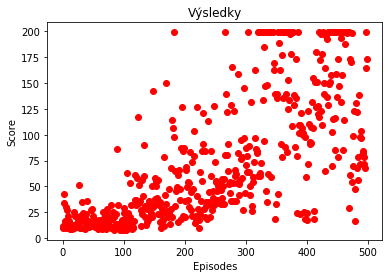

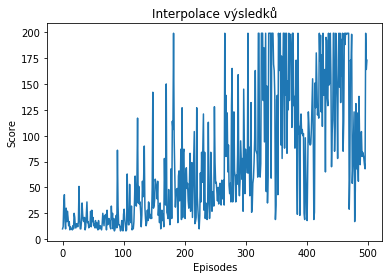

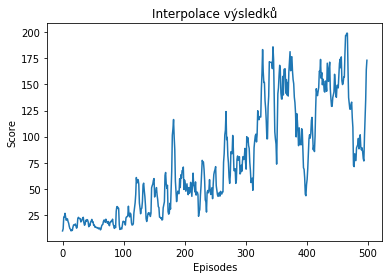

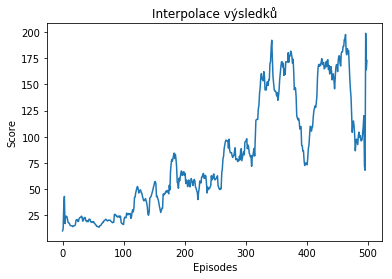

In [71]:
import copy
#global score1
score1 = copy.copy(scores)
#global score2
score2 = copy.copy(scores)

for i in range (len(scores)):
    if i > 1 and i < 498:
        score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5
        
for i in range (len(scores)):
    if i > 4 and i < 495:
        score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
        score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
        score2[i] = score2[i]/10


#for i in range (len(scores)):
#    if i > 1 and i < 498:
#        score2[i] = (score2[i - 2] + score2[i - 1] + score2[i] + score2[i + 1] + score2[i + 2])/5

#for i in range (len(scores)):
#    print("{}, {}, {}".format(scores[i], score1[i], score2[i]))

plt.plot(episodesList, scores, 'ro')
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Výsledky")
plt.show()

plt.plot(scores)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Interpolace výsledků")
plt.show()

plt.plot(score1)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Interpolace výsledků")
plt.show()

plt.plot(score2)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Interpolace výsledků")
plt.show()


        

#plt.plot(episodesList, score1, 'ro')
#plt.ylabel("Score")
#plt.xlabel("Episodes")
#plt.show()


#plt.plot(episodesList, score2, 'ro')
#plt.ylabel("Score")
#plt.xlabel("Episodes")
#plt.show()